# Ćwiczenia 4 - Regularyzacja

## Early stopping
Polega na zatrzymaniu uczenia w momencie kiedy wybrana metryka przestała się poprawiać dla danych walidacyjnych.
Keras pozwala na zaimplementowac tę metodę jako callback, który można podać jako parametr w metodzie `fit`, np.:

```python
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)

model.fit(..., callbacks=[early_stopping])
```

## Regularyzacja L1/L2

Do funkcji błędu dodawany jest dodatkowy termin penalizujący zbyt duże wagi:

$$ \tilde{J}(W) = J(W) + \lambda \sum_i w_i^2 $$
$$ \tilde{J}(W) = J(W) + \lambda \sum_i |w_i| $$

Aby zastosować tę metodę dla warstwy, należy ustawić parametr `kernel_regularizer`, np:

```python
tf.keras.layers.Dense(..., kernel_regularizer=tf.keras.regularizers.l2(0.1))
```

## Regularyzacja Dropout

Regularyzacja Dropout polega na losowym wyłączaniu pewnej części neuronów w sieci podczas uczenia.
Metodę tę można zaimplementowac dodając warstwę `Dropout` bezpośrednio po regularyzowanej warstwie.

## Augmentacja danych

Polega na wprowadzaniu drobnych zmian w danych treningowych.
Technika ta jest szczególnie przydatna w przetwarzaniu obrazów. Różne transformacje można zastosować dodając odpowiednie warstwy na wejściu sieci, np.: `RandomRotation`, `RandomZoom`, `RandomBrightness`. Pełna lista dostępncyh transformacji: https://keras.io/api/layers/preprocessing_layers/image_augmentation/

## Zadania
1. Wczytaj zbiór `imdb` z Ćwiczeń 03. Zastosuj sieć wielowarstwową do klasyfikacji zbioru (możesz wykorzystać sieć z przykładu). Stwórz wykres pokazujący błąd dla danych treningowych/walidacyjnych w kolejnych epokach i zaobserwuj efekt przetrenowania. Następnie uruchom sieć ponownie, stosując Early Stopping aby zatrzymać uczenie w momencie, kiedy funkcja straty przestanie się zminiejszać dla danych walidacyjnych.
2. Dodaj do warstw ukrytych sieci z Zadania 1. regularyzację L1/L2. Dobierz odpowiednie wartości współczynnika regularyzacji. Trenuj sieci bez stosowania Early Stopping. Stwórz wykresy krzywych uczenia i porównaj działanie regularyzowanych sieci z siecią z Zadania 1.
3. Dodaj do warstw ukrytych sieci z Zadania 1. regularyzację Dropout. Dobierz odpowiedni parametr `rate`. Stwórz wykres krzywej uczenia i porównaj działanie sieci stosującej Dropout z siecią z Zadania 1.
4. (opcjonalne) Dodaj do sieci klasyfikującej zbiór CIFAR-10 stworzonej na wcześniejszych zajęciach augmentację obrazów. Bezpośrednio po warstwie `Input` i przed warstwą `Flatten` dodaj wybrane transformacje.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.pyplot as plt

In [2]:
def plot_history(history):
  fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  print(history.history.keys())
  epoch = range(len(loss))

  ax1.plot(epoch, loss, label="Training Loss")
  ax1.plot(epoch, val_loss, label="Validation Loss")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")
  ax1.legend()

  ax2.plot(epoch, accuracy, label="Training Accuracy")
  ax2.plot(epoch, val_accuracy, label="Validation Accuracy")
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("Loss")
  ax2.legend()

In [3]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

mlb = MultiLabelBinarizer()
mlb.fit(train_data + test_data)
X_train_full = mlb.transform(train_data)
y_train_full = train_labels
X_test = mlb.transform(test_data)
y_test = test_labels

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.33, random_state=911)

In [37]:
lambda_constant = 0.01
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(l2=lambda_constant)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [38]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=36)

Epoch 1/36
524/524 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.7889 - loss: 0.8378 - val_accuracy: 0.8562 - val_loss: 0.6514
Epoch 2/36
524/524 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.8799 - loss: 0.5975 - val_accuracy: 0.8522 - val_loss: 0.5975
Epoch 3/36
524/524 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8852 - loss: 0.5442 - val_accuracy: 0.8438 - val_loss: 0.5894
Epoch 4/36
524/524 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8991 - loss: 0.4829 - val_accuracy: 0.8693 - val_loss: 0.5369
Epoch 5/36
524/524 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9114 - loss: 0.4367 - val_accuracy: 0.8558 - val_loss: 0.5313
Epoch 6/36
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9171 - loss: 0.3966 - val_accuracy: 0.8685 - val_loss: 0.5109
Epoch 7/36
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9202 - loss: 0.3734 - val_accuracy: 0.8564 - val_loss: 0.5017
Epoch 8/36
524/524 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9207 - loss: 0.3647 - val

In [ ]:
plot_history(history)

In [4]:
!pip install keras-tuner

In [17]:
import keras_tuner as kt

def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))

    model.add(tf.keras.layers.Dense(
        units=hp.Int('units_1', min_value=2, max_value=6, step=2),
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L2(hp.Choice('l2', [0.001, 0.01, 0.1]))
    ))
    model.add(tf.keras.layers.BatchNormalization()),
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units_1', min_value=2, max_value=6, step=2),
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L2(hp.Choice('l2', [0.001, 0.01, 0.1]))
    ))
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units_1', min_value=2, max_value=6, step=2),
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L2(hp.Choice('l2', [0.001, 0.01, 0.1]))
    ))
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units_1', min_value=2, max_value=6, step=2),
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L2(hp.Choice('l2', [0.001, 0.01, 0.1]))
    ))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [0.001, 0.005, 0.01])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [19]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='imdb_tuning'
)

tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_valid, y_valid))

Trial 10 Complete [00h 01m 12s]
val_accuracy: 0.8664242625236511

Best val_accuracy So Far: 0.8775757551193237
Total elapsed time: 00h 11m 03s


In [7]:
tuner

In [20]:
best_model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [21]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6)              │        59,994 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6)              │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,151 (234.96 KB)

 Trainable params: 60,139 (234.92 KB)

 Non-trainable params: 12 (48.00 B)

In [22]:
best_history = best_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=36)

Epoch 1/36
524/524 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9281 - loss: 0.2228 - val_accuracy: 0.8684 - val_loss: 0.3746
Epoch 2/36
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9466 - loss: 0.1926 - val_accuracy: 0.8684 - val_loss: 0.4286
Epoch 3/36
524/524 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9581 - loss: 0.1731 - val_accuracy: 0.8669 - val_loss: 0.4836
Epoch 4/36
524/524 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9676 - loss: 0.1561 - val_accuracy: 0.8629 - val_loss: 0.4819
Epoch 5/36
524/524 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9699 - loss: 0.1585 - val_accuracy: 0.8652 - val_loss: 0.5167
Epoch 6/36
524/524 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9698 - loss: 0.1588 - val_accuracy: 0.8594 - val_loss: 0.5555
Epoch 7/36
524/524 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9744 - loss: 0.1526 - val_accuracy: 0.8450 - val_loss: 0.5868
Epoch 8/36
524/524 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9788 - loss: 0.1466 - val_accura

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


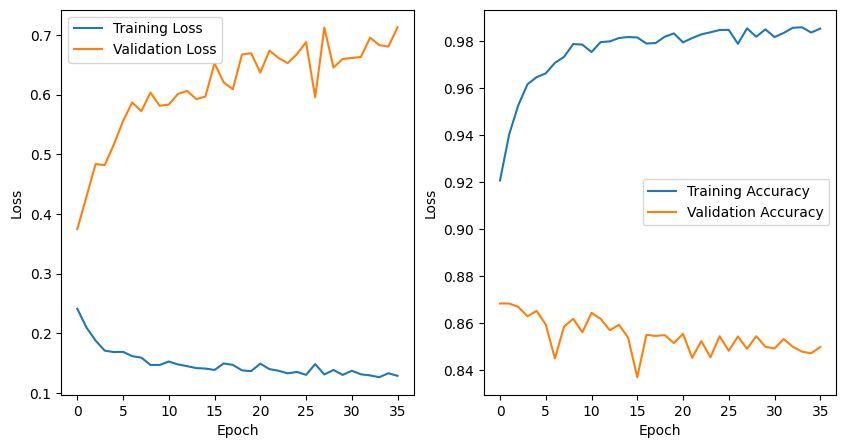

In [23]:
plot_history(best_history)